In [1]:
import wmfdata as wmf
import pandas as pd
import numpy as np
from wmfdata import spark,hive
from datetime import datetime

You are using Wmfdata v2.0.0, but v2.0.1 is available.

To update, run `pip install --upgrade git+https://github.com/wikimedia/wmfdata-python.git@release`.

To see the changes, refer to https://github.com/wikimedia/wmfdata-python/blob/release/CHANGELOG.md.


In [32]:
# Load data
wikis=pd.read_csv('data/wikis')
file = "https://analytics.wikimedia.org/published/datasets/knowledge_gaps/content_gaps/csv/gender.csv"
gendata = pd.read_csv(file)
# only wikipedia projects
gendata=gendata[gendata.wiki_db.isin(list(wikis['database_code']))]


In [33]:
# load original gen_data

old_gen = pd.read_csv('data/updated_gender.csv') 
old_gen['time'] = pd.to_datetime(old_gen['time'])


In [34]:
# Define a function to map categories to the new categories
def map_gender_category(category):
    if category in ['male', 'cisgender male']:
        return 'male'
    elif category in ['female', 'cisgender female']:
        return 'female'
    else:
        return 'gender_diverse'

# Create a new column gender3category
gendata['gender3category'] = gendata['category'].apply(map_gender_category)


In [35]:
#overtime quality articles
gen3quality=gendata.groupby(['gender3category','time_bucket'])['standard_quality_count_value'].sum().reset_index()

# Pivot the dataframe
gen3quality = gen3quality.pivot(index='time_bucket', columns='gender3category', values='standard_quality_count_value').reset_index()
#gen3quality = gen3quality[gen3quality['time_bucket'] != '2023-09']


In [36]:
#aggregate
gen3quality['time'] = pd.to_datetime(gen3quality['time_bucket'])

# Identify the latest 'time' in old_geo_data
latest_time = old_gen['time'].max()

# Filter rows from total quality articles where 'time' is greater than latest_time from old_data to identify rows to be added
filtered_rows = gen3quality[gen3quality['time'] > latest_time]



# Filter columns of last_row based on columns in geo_data
old_gen = pd.concat([old_gen, filtered_rows], axis=0, ignore_index=True, sort=False)



In [37]:
# check if any new data was added to the spreadsheet


'''
The code below computes the monthly metric and the quarterly metric in the following way:

1) Monthly metric: Contained in the column called 'metric_underrepresented'.  It is computed as the MoM-difference.

2) Quarterly metric: Conatained in the column called 'quarterly_metric'.  It is computed as the average of MoM-difference of the monthly metrics of July 2023 and August 2023.  Since September data is not fully available, 
it is just the average of the first 2 months in the quarter (July and August).

'''



if filtered_rows.empty:
    print("No data has been added to the original spreadsheet. Will not overwrite updated_gender.csv")    
    mom_gen_data = old_gen.copy()
    mom_gen_data = mom_gen_data.drop(columns=['time_bucket']) # use old_gen as output since no new rows were added.
    
else:
    # Compute the Year-over-Year difference
    mom_gen_data = old_gen.copy()

    # Compute the 12-month MoM difference for "female" column
    mom_gen_data['female_MoM_difference'] = mom_gen_data['female'].diff()


    # Compute the 12-month MoM difference for men column
    mom_gen_data['men_MoM_difference'] = mom_gen_data['male'].diff()


    # Compute the 12-month MoM difference for gender diverse column
    mom_gen_data['gender_diverse_MoM_difference'] = mom_gen_data['gender_diverse'].diff()
    
    
# Get total
    columns_to_sum = ['female_MoM_difference', 'men_MoM_difference', 'gender_diverse_MoM_difference']
    mom_gen_data['total'] = mom_gen_data[columns_to_sum].sum(axis=1)
    mom_gen_data['total_gender_minority'] =  mom_gen_data[['female_MoM_difference', 'gender_diverse_MoM_difference']].sum(axis=1)
    


    # create proportion column to capture women + gender diverse
    mom_gen_data['metric_gender_diverse+women'] = mom_gen_data[['female_MoM_difference','gender_diverse_MoM_difference']].sum(axis=1)/mom_gen_data['total'] * 100

    # Reorder columns to make 'time' the first column
    mom_gen_data = mom_gen_data[['time'] + [col for col in mom_gen_data if col != 'time']]
   
    # Round the columns and drop extra columns
    columns_to_round = [col for col in mom_gen_data.columns if col not in ['metric_gender_diverse+women', 'time']]
    mom_gen_data[columns_to_round] = mom_gen_data[columns_to_round].round(decimals=0)
    mom_gen_data = mom_gen_data.drop(columns=['time_bucket'])
    
    # Make metric column into %
    
    #mom_gen_data['proportion_of_non_male'] = mom_gen_data['metric_gender_diverse+women'] 
    #mom_gen_data['metric_gender_diverse+women'] = (mom_gen_data['metric_gender_diverse+women'] * 100).round()
    #mom_gen_data['metric_gender_diverse+women'] = mom_gen_data['metric_gender_diverse+women'].replace([np.inf, -np.inf, np.nan], 0).astype(int).astype(str) + '%'

    
    quart_df = mom_gen_data.copy()

    # Filter the copied DataFrame for the rows of August and July 2023
    august_july_data = quart_df[quart_df['time'].isin([pd.Timestamp('2023-09-01'),pd.Timestamp('2023-08-01'), pd.Timestamp('2023-07-01')])]

    # Specify columns to average
    cols_to_average = ['female_MoM_difference', 'men_MoM_difference', 'gender_diverse_MoM_difference']
    average_values = august_july_data[cols_to_average].mean()

    # Replace values in the row corresponding to '2023-09-01' with average_values
    quart_df.loc[quart_df['time'] == '2023-09-01', cols_to_average] = average_values.values
    quart_df['total'] = quart_df[['female_MoM_difference', 'men_MoM_difference', 'gender_diverse_MoM_difference']].sum(axis=1)

    # Calculate the quarterly metric as a proportion of gender_diverse_MoM_difference and female_MoM_difference
    quart_df['quarterly_metric'] = ((quart_df['gender_diverse_MoM_difference'] + quart_df['female_MoM_difference']) / quart_df['total']) * 100

    # Append the created quarterly_metric column to mom_gen_data
    mom_gen_data['quarterly_metric'] = quart_df['quarterly_metric']
    
    
    #output
    
    mom_gen_data.to_csv('data/updated_gender.csv', index=False)
    print("updated csv file")

updated csv file


# Naive Forecast

In [38]:
'''
The forecast is calculated by getting the rate of change from the same period last year and the period that followed it for the underrepresented proportion and the overall new article count, then applying that rate of change to the values of the current period
to create a forecasted estimate of the subset of interest (gender diverse + women) totals and overall totals and then getting the difference of these values to compute an estimate of the proportion for the next period.  For the quarterly forecast, the value of the first period is determine by taking
the average of the available data for the quarter.

'''

# Define the months for q1 and q2
q1_dates = ['2022-07-01', '2022-08-01', '2022-09-01']
q2_dates = ['2022-10-01', '2022-11-01', '2022-12-01']

# Filter the data for q1 and q2 separately
q1_data = mom_gen_data[mom_gen_data['time'].isin(q1_dates)]
q2_data = mom_gen_data[mom_gen_data['time'].isin(q2_dates)]

# Calculate the average combined values for female + gender diverse and men for Q1
avg_combined_female_gender_q1 = (q1_data['female_MoM_difference'] + q1_data['gender_diverse_MoM_difference']).mean()
avg_total_q1 =  (q1_data['female_MoM_difference'] + q1_data['gender_diverse_MoM_difference'] + q1_data['men_MoM_difference']).mean()

# Calculate the average combined values for female + gender diverse and men for Q2
avg_combined_female_gender_q2 = (q2_data['female_MoM_difference'] + q2_data['gender_diverse_MoM_difference']).mean()
avg_total_q2 =  (q2_data['female_MoM_difference'] + q2_data['gender_diverse_MoM_difference'] + q2_data['men_MoM_difference']).mean()

# Calculate the rate of change from Q1 to Q2 for female + gender diverse
roc_female_gender = (avg_combined_female_gender_q2 - avg_combined_female_gender_q1) / avg_combined_female_gender_q1

# Calculate the rate of change from Q1 to Q2 for the total
roc_total_q = (avg_total_q2  - avg_total_q1 ) / avg_total_q1 

# Apply the rate of change to estimate the values in combined_df which contains the values of the gender categories MoM difference for the quarter (the average of July and August)
quart_df['forecasted_female_gender'] = quart_df['female_MoM_difference'] + quart_df['gender_diverse_MoM_difference']
quart_df['forecasted_female_gender'] = quart_df['forecasted_female_gender'] * (1 + roc_female_gender)

quart_df['forecasted_total'] = quart_df['total'] * (1 + roc_total_q)

# Calculate forecasted_total
#quart_df['forecasted_total'] = quart_df['forecasted_female_gender'] + quart_df['forecasted_men']
quart_df['forecasted_quarterly_metric'] = quart_df['forecasted_female_gender'] / quart_df['forecasted_total']


# Print the forecasted metric for the row of 2023-09-01
forecast_value = quart_df.loc[quart_df['time'] == '2023-09-01', 'forecasted_quarterly_metric'].values[0]
#print(f"The forecasted metric for Q2 2023 is: {forecast_value:.2%}")


# Monthly forecast

m1_dates = ['2022-09-01']
m2_dates = ['2022-10-01']

# Filter the data for q1 and q2 separately
m1_data = mom_gen_data[mom_gen_data['time'].isin(m1_dates)]
m2_data = mom_gen_data[mom_gen_data['time'].isin(m2_dates)]

# Calculate the combined values for female + gender diverse and men for Q1
combined_female_gender_m1 = m1_data['female_MoM_difference'].values[0] + m1_data['gender_diverse_MoM_difference'].values[0]
total_m1 = m1_data['men_MoM_difference'].values[0]+ m1_data['female_MoM_difference'].values[0] + m1_data['gender_diverse_MoM_difference'].values[0]

# Calculate the combined values for female + gender diverse and men for Q2
combined_female_gender_m2 = m2_data['female_MoM_difference'].values[0] + m2_data['gender_diverse_MoM_difference'].values[0]
total_m2 = m2_data['men_MoM_difference'].values[0]+ m2_data['female_MoM_difference'].values[0] + m2_data['gender_diverse_MoM_difference'].values[0]

# Calculate the rate of change from Q1 to Q2 for female + gender diverse
roc_female_gender_m = (combined_female_gender_m2 - combined_female_gender_m1) / combined_female_gender_m1

# Calculate the rate of change from Q1 to Q2 for men
roc_total_m = (total_m2 - total_m1) / total_m1

# Make a copy of the dataframe that contains the monthly values
monthly_forecast = mom_gen_data.copy()

# Apply the rate of change to estimate the values in combined_df which contains the values of the gender categories MoM difference for the quarter (the average of July and August)
monthly_forecast['forecasted_female_gender'] = monthly_forecast['female_MoM_difference'] + monthly_forecast['gender_diverse_MoM_difference']
monthly_forecast['forecasted_female_gender'] = monthly_forecast['forecasted_female_gender'] * (1 + roc_female_gender_m)

monthly_forecast['forecasted_total'] = monthly_forecast['total'] * (1 + roc_total_m)



# Calculate forecasted_total
#monthly_forecast['forecasted_total'] = monthly_forecast['forecasted_female_gender'] + monthly_forecast['forecasted_men']
monthly_forecast['forecasted_monthly_metric'] = monthly_forecast['forecasted_female_gender'] / monthly_forecast['forecasted_total']

# Print the forecasted metric for the row of 2023-09-01
forecast_value_m = monthly_forecast.loc[monthly_forecast['time'] == '2023-09-01', 'forecasted_monthly_metric'].values[0]
#print(f"The forecasted monthly metric for September 2023 is: {forecast_value_m:.2%}")

In [39]:
mom_data = mom_gen_data.copy() # Copy primary dataframe

# Append forecast to primary dataframe
mom_data['forecasted_monthly_metric'] = monthly_forecast['forecasted_monthly_metric']
mom_data['forecasted_quarterly_metric'] = quart_df['forecasted_quarterly_metric']

mom_data['forecasted_monthly_metric'] = mom_data['forecasted_monthly_metric'].round(4)*100
mom_data['forecasted_quarterly_metric'] = mom_data['forecasted_quarterly_metric'].round(4)*100

mom_data['metric_gender_diverse+women'] = mom_data['metric_gender_diverse+women'].round(4)
mom_data['quarterly_metric'] = mom_data['quarterly_metric'].round(4)

# Set all rows except the last one to NaN because forecasts, quarterly metric have not been computed or needed for historical data
mom_data['quarterly_metric'].iloc[:-1] = np.nan
mom_data['forecasted_monthly_metric'].iloc[:-1] = np.nan
mom_data['forecasted_quarterly_metric'].iloc[:-1] = np.nan

mom_data.to_csv('data/updated_gender.csv', index=False)
mom_data.tail(1)


/tmp/ipykernel_10496/3194413587.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mom_data['quarterly_metric'].iloc[:-1] = np.nan
/tmp/ipykernel_10496/3194413587.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mom_data['forecasted_monthly_metric'].iloc[:-1] = np.nan
/tmp/ipykernel_10496/3194413587.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mom_data['forecasted_quarterly_metric'].iloc[:-1] = np.nan


,time,female,male,gender_diverse,female_MoM_difference,men_MoM_difference,gender_diverse_MoM_difference,total_gender_minority,total,metric_gender_diverse+women,quarterly_metric,forecasted_monthly_metric,forecasted_quarterly_metric
272,2023-09-01,358418.0,1262633.0,4088.0,2943.0,9826.0,36.0,2979.0,12805.0,23.2643,24.2346,22.08,20.77


# Generate monthly chart

Generating Women % Distribution chart...


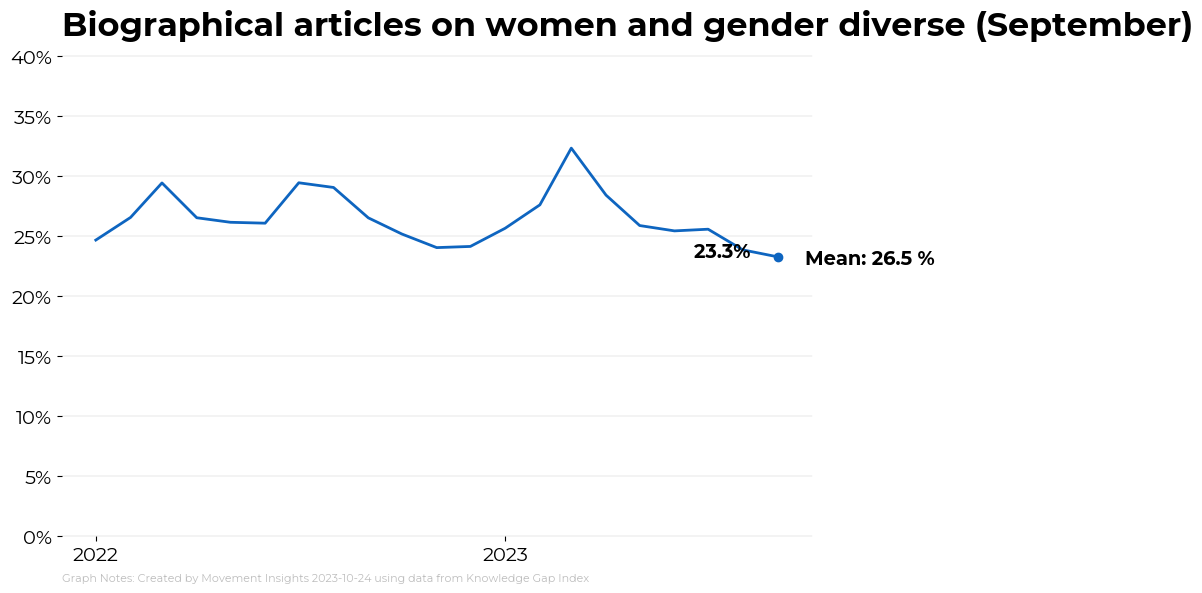

In [9]:
%run gender_gap_plot.ipynb